In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
warnings.simplefilter('ignore')
from sklearn import preprocessing
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR



matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
data = pd.read_csv('return.csv')

In [3]:
data['YearMonth'] = pd.to_datetime(data['YearMonth'], format='%Y%m', errors='coerce')
data = data.rename(columns={"YearMonth": "date",'red_ret':'residual return','cov_ret':'conventional return'})

# 1. Time Series Analysis for Residual Strategy's Return

In [4]:
df_residual = data[['date','residual return']]
df_residual['date'].min(), df_residual['date'].max()

(Timestamp('1929-08-01 00:00:00'), Timestamp('2019-06-01 00:00:00'))

In [5]:
df_residual = df_residual.sort_values('date')
df_residual = df_residual.set_index('date')

## 1.1 Time Series Visualization

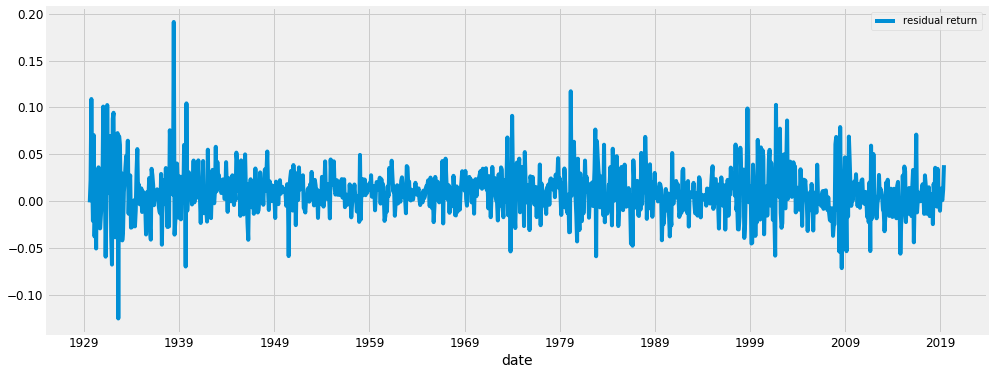

In [6]:
df_residual.plot(figsize=(15, 6))
plt.show()

## 1.2 Visualization of Decomposition 

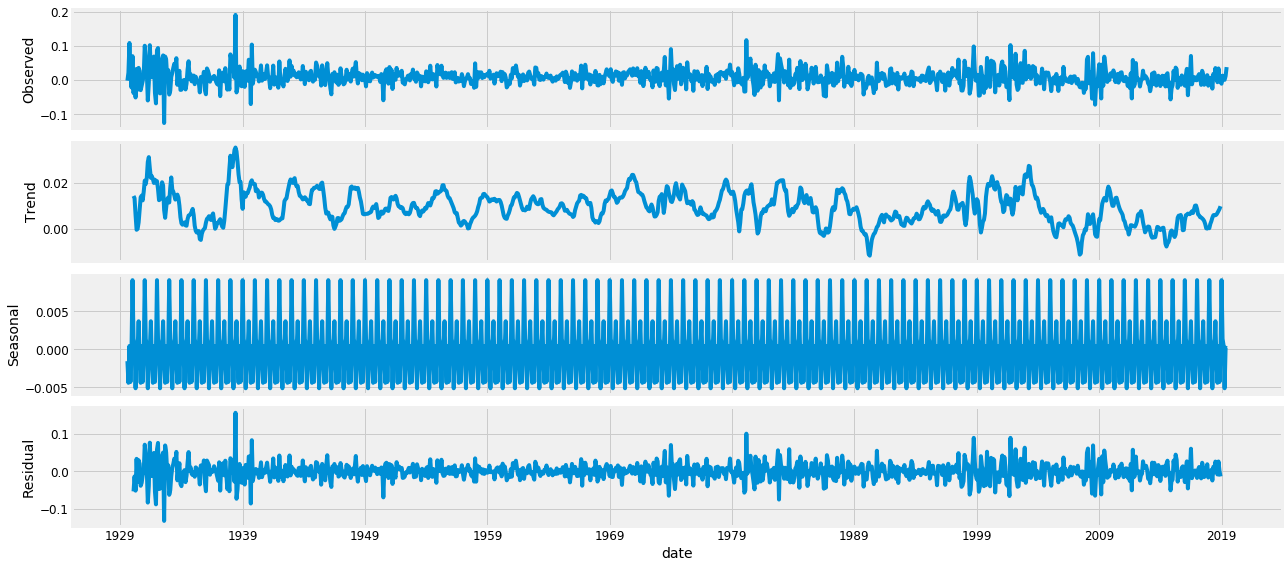

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_residual, model='additive')
fig = decomposition.plot()
plt.show()

In [8]:
def extract_quarter(date):
    temp = int(date[5:7])
    if temp >= 10:
        output = 4
    elif temp >= 7:
        output = 3
    elif temp >=4:
        output = 2
    else:
        output = 1
    return output

In [9]:
data_plot = df_residual.copy()
data_plot = data_plot.reset_index()
data_plot['Month'] = data_plot['date'].astype(str).apply(lambda x:int(x[5:7]))
data_plot['Year'] = data_plot['date'].astype(str).apply(lambda x:int(x[0:4]))
data_plot['Quarter'] = data_plot['date'].astype(str).apply(lambda x: extract_quarter(x))
data_plot_month = data_plot.groupby('Month')['residual return'].mean()
data_plot_quarter = data_plot.copy()
data_plot_quarter['residual return'] = data_plot_quarter['residual return']+1
data_plot_quarter = data_plot_quarter.groupby(['Quarter','Year'])['residual return'].prod()
data_plot_quarter = data_plot_quarter.reset_index()
data_plot_quarter['residual return'] = data_plot_quarter['residual return'] - 1
data_plot_quarter = data_plot_quarter.groupby('Quarter')['residual return'].mean()

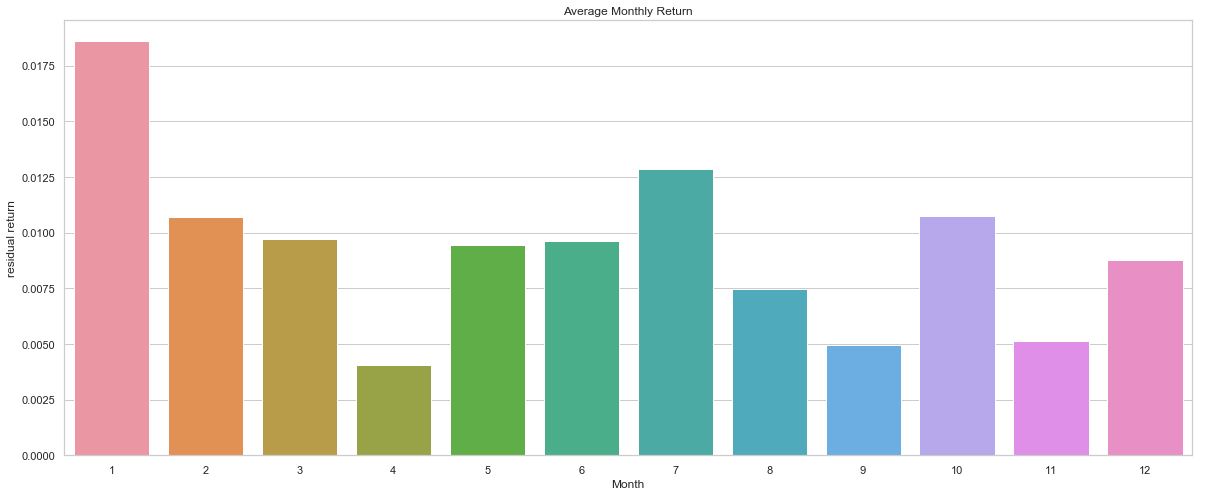

In [10]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="Month", y="residual return", data=data_plot_month.reset_index()).set_title('Average Monthly Return')

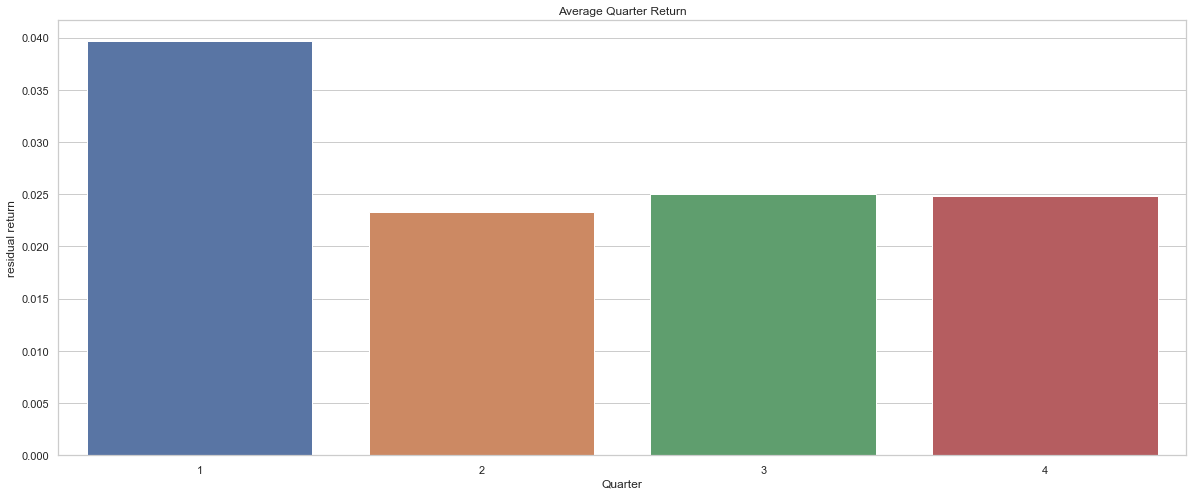

In [11]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="Quarter", y="residual return", data=data_plot_quarter.reset_index()).set_title('Average Quarter Return')

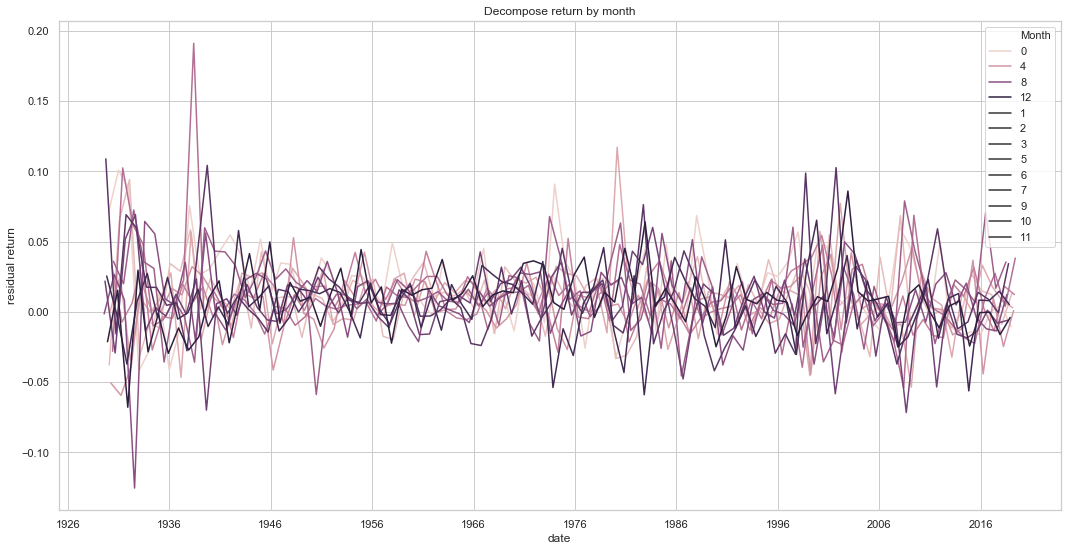

In [12]:
plt.figure(figsize = (16,9))
ax = sns.lineplot(x='date', y="residual return", hue='Month', style='Month', data=data_plot,dashes=False)
plt.title('Decompose return by month')
# ax.set(yscale="log")
# plt.ylim=(-1000, 17000)
# plt.savefig('FF3_vs_FF5.png')
plt.show()

## 1.3 Test the Return with ARIMA

In [8]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [9]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_residual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-4758.698497167039
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-4752.303698301244
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:-4734.5881207091425
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-4160.226262059151
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-4792.230750247525
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-4759.149594249726
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:-2979.703511107208
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:-4061.8420508499203
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:-4657.490350961446
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-4760.580389787119
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-4827.008652242977
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-4791.709574063652
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-4428.763313202211
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-4791.086330232028
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-4771.015735003128
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:-3546.8276863506103
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:-4317.324690928597
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:-4622.59

ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:-4413.084887239329
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:-4759.771848346977
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:-4751.497926321006
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:-3531.738255525558
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:-4290.485774873607
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:-4511.334492293196
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:-4843.831632080475
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:-4853.558448775959
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:-4862.851672159041
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:-4503.902355651291
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:-4757.050868994936
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:-4737.587611238129
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:-3846.779049309936
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:-4378.999186472429
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:-4361.429479888402
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:-2976.1766466493136
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:-2980.271235371288
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:-2957.9754

ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:-4752.214875474681
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:-3881.169468145341
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:-4430.393621996627
ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:-4575.646554738909
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:-4886.278286336596
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:-4860.335349830457
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:-4835.548305457111
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:-4216.070044739527
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:-4791.615409899187
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:-4740.3306902894865
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:-2989.9965085959047
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:-4052.2785872084996
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:-4655.142014045776
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:-4867.631433648075
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:-4863.050205870986
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:-4848.694624572898
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:-4424.084597862049
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:-4776.99

ARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:-3559.319888446149
ARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:-4202.7916374746765
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:-4367.644409795639
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:-4361.971499008312
ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:-4390.719326961464
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:-3921.6145669140246
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:18592.799785478906
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:-4285.956225856794
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:-3044.498353207379
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:-3800.3763481655355
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:-4061.4282010956754
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:-4354.17835865853
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:-4385.344323420317
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:-4410.767537991815
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:-4055.8374908919636
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:-4255.122463916618
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:-4254.658903203685
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:-3414.0

ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:-4556.488301999714
ARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:-4580.927613103169
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:-4211.4614068863475
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:-4447.656976340755
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:-4447.996796682088
ARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:-3566.4108256118725
ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:-4112.838353827903
ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:-4304.892735112771
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:-4889.569822761319
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:-4862.288702036647
ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:-4836.5790987627215
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:-4152.311867204617
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-4777.1092491957825
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:-4748.790523484201
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:-2973.7187299946268
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:-4038.221252459832
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:-4638.031223683327
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-4863.

ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-4893.3103738319915 has the lowest AIC, therefore considered to be the optimal solution

In [10]:
mod = sm.tsa.statespace.SARIMAX(df_residual,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.000   2323.464      0.000       0.998       1.000
ma.L1         -1.0000      1.958     -0.511      0.609      -4.837       2.837
sigma2         0.0006      0.001      0.511      0.609      -0.002       0.003


AR1 model works!

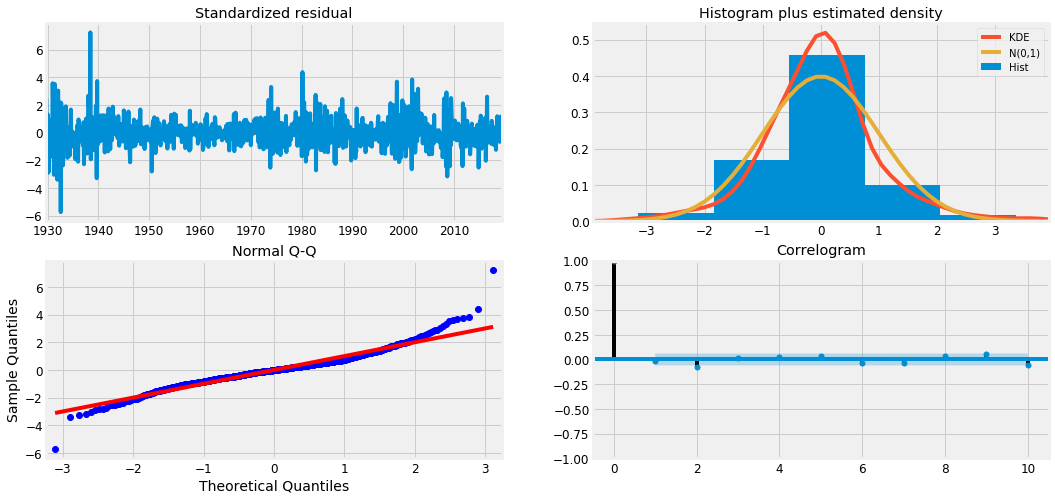

In [11]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### 1.4 Test with AR

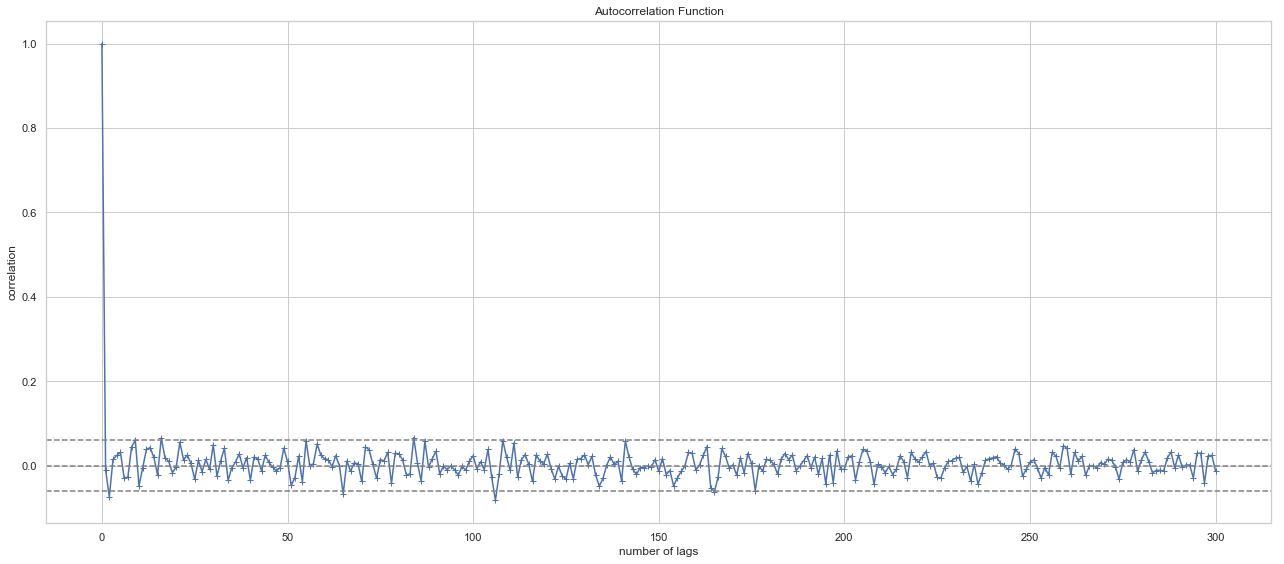

In [13]:
lag_acf = sm.tsa.stattools.acf(df_residual, nlags=300)
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_residual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_residual)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

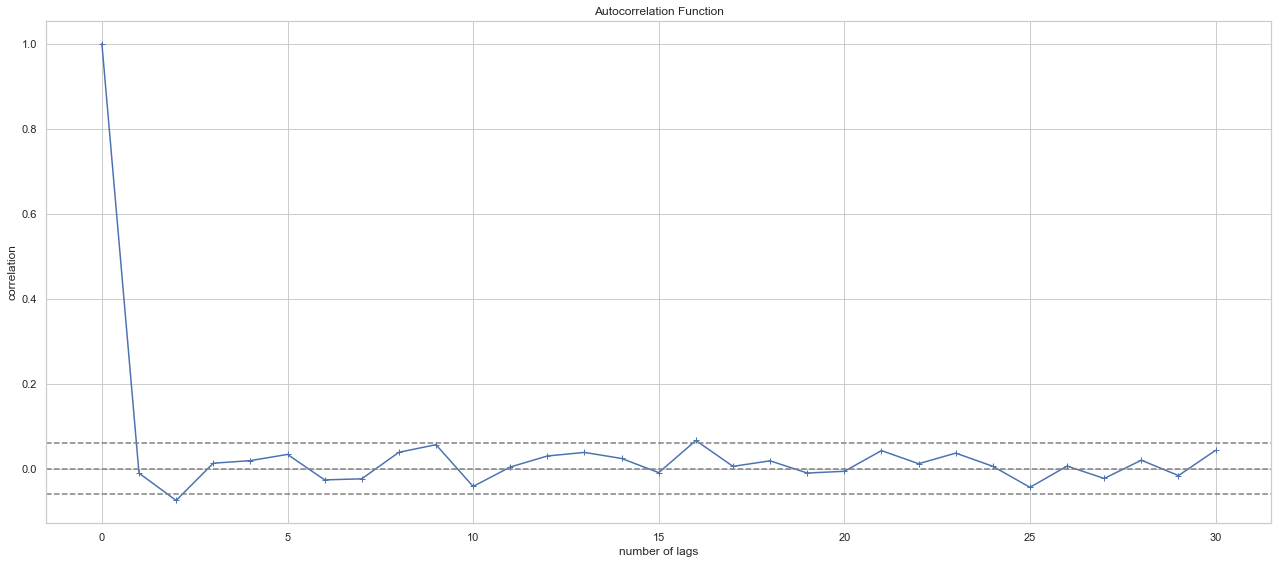

In [14]:
lag_pacf = sm.tsa.stattools.pacf(df_residual, nlags=30, method='ols')
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_residual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_residual)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [15]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_residual['residual return'].values, order=(2,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1079
Model:                     ARMA(2, 0)   Log Likelihood                2457.069
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sun, 08 Dec 2019   AIC                          -4906.139
Time:                        16:41:37   BIC                          -4886.204
Sample:                             0   HQIC                         -4898.590
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.001     13.397      0.000       0.008       0.011
ar.L1.y       -0.0108      0.030     -0.357      0.721      -0.070       0.049
ar.L2.y       -0.0742      0.030     -2.444      0.0

- The return of residual reversal strategy is highly correlated with the return two months ago

# 2. Return with Other Variables

In this section, we tested the return along with other indexes and variables including:

Financial Conditions

    NFCI: National Financial Conditions Index
    STLFSI: St. Louis Fed Financial Stress Index
    KCFSI: Kansas City Financial Stress Index
    VIX: Volatility 
    
Interest Rates:

    FedFund: Effective Federal Funds Rate
    BAA: Baa-rated corporate
    Treas2y: 2-yr Treasury
    Treas10y: 10-yr Treasury

Yield Spread:

    LiborOIS_3mo: 3 month London Interbank Offering Rate-Overnight Index Swap spread
    YieldCurve_10yr3mo: Yield curve, 10-year Treasury minus 3-month Treasury
    CPS_3mo: 3-month commercial paper minus 3-month Treasury bill
    TED: 3-month Treasury-EuroDollar Spread (TED Spread)


- We use the Granger's Causation Test Along with the Vectorized AutoRegression to find out whether the variables have causation effect to our residual reversal strategy's return

## 2.1 Data Processing

In [16]:
df_red = df_residual.copy()
df_red = df_red.reset_index()
df_red['date'] = df_red['date'].astype(str).apply(lambda x: x[:4]+x[5:7])
df_red = df_red.rename(columns = {'date':'DATE'})

In [17]:
#our return data
df_red = df_residual.copy()
df_red = df_red.reset_index()
df_red['date'] = df_red['date'].astype(str).apply(lambda x: x[:4]+x[5:7])
df_red = df_red.rename(columns = {'date':'DATE'})

In [18]:
#NFCI
NFCI = pd.read_csv('NFCI_1971_08.csv')
NFCI['DATE'] = NFCI['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
NFCI = NFCI.groupby(['DATE']).mean()
NFCI = NFCI.reset_index()

In [92]:
NFCI_df = pd.merge(NFCI,df_red,how = 'left',on=['DATE'])
NFCI_df['DATE'] = pd.to_datetime(NFCI_df['DATE'], format='%Y%m', errors='coerce')
NFCI_df = NFCI_df.set_index('DATE')
#NFCI_df['NFCI'] = NFCI_df['NFCI'].diff()
#NFCI_df = NFCI_df.dropna()
NFCI_df['NFCI'] = NFCI_df['NFCI'].shift(1)
NFCI_df = NFCI_df.dropna()

In [19]:
#STLFSI
STLFSI = pd.read_csv('STLFSI.csv')
STLFSI['DATE'] = STLFSI['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
STLFSI = STLFSI.groupby(['DATE']).mean()
STLFSI = STLFSI.reset_index()

In [93]:
STLFSI_df = pd.merge(STLFSI,df_red,how = 'left',on=['DATE'])
STLFSI_df['DATE'] = pd.to_datetime(STLFSI_df['DATE'], format='%Y%m', errors='coerce')
STLFSI_df = STLFSI_df.set_index('DATE')
#STLFSI_df['STLFSI'] = STLFSI_df['STLFSI'].diff()
#STLFSI_df = STLFSI_df.dropna()
STLFSI_df['STLFSI'] = STLFSI_df['STLFSI'].shift(1)
STLFSI_df = STLFSI_df.dropna()
#regression(STLFSI_df['STLFSI'],STLFSI_df['residual return'])

In [20]:
#KCFSI
KCFSI = pd.read_csv('KCFSI.csv')
KCFSI['DATE'] = KCFSI['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])

In [94]:
KCFSI_df = pd.merge(KCFSI,df_red,how = 'left',on=['DATE'])
KCFSI_df['DATE'] = pd.to_datetime(KCFSI_df['DATE'], format='%Y%m', errors='coerce')
KCFSI_df = KCFSI_df.set_index('DATE')
#KCFSI_df['KCFSI'] = KCFSI_df['KCFSI'].diff()
#KCFSI_df = KCFSI_df.dropna()
KCFSI_df['KCFSI'] = KCFSI_df['KCFSI'].shift(1)
KCFSI_df = KCFSI_df.dropna()
#regression(KCFSI_df['KCFSI'],KCFSI_df['residual return'])

In [21]:
#VIX
VIX = pd.read_csv('VIX_1990_01_daily.csv')
VIX['DATE'] = VIX['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
VIX['VIXCLS'] = VIX['VIXCLS'].apply(pd.to_numeric, errors='coerce').ffill(axis = 0)
VIX = VIX.groupby(['DATE']).mean()
VIX = VIX.reset_index()
VIX = VIX.rename(columns = {'VIXCLS':'VIX'})

In [95]:
VIX_df = pd.merge(VIX,df_red,how = 'left',on=['DATE'])
VIX_df['DATE'] = pd.to_datetime(VIX_df['DATE'], format='%Y%m', errors='coerce')
VIX_df = VIX_df.set_index('DATE')
#VIX_df['VIX'] = VIX_df['VIX'].diff()
#VIX_df = VIX_df.dropna()
VIX_df['VIX'] = VIX_df['VIX'].shift(1)
VIX_df = VIX_df.dropna()
#regression(VIX_df['VIX'],VIX_df['residual return'])

In [22]:
#FedFund
FedFund = pd.read_csv('FEDFUNDS_1954_07.csv')
FedFund['DATE'] = FedFund['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])

In [96]:
FedFund_df = pd.merge(FedFund,df_red,how = 'left',on=['DATE'])
FedFund_df['DATE'] = pd.to_datetime(FedFund_df['DATE'], format='%Y%m', errors='coerce')
FedFund_df = FedFund_df.set_index('DATE')
#FedFund_df['FEDFUNDS'] = FedFund_df['FEDFUNDS'].diff()
#FedFund_df = FedFund_df.dropna()
FedFund_df['FEDFUNDS'] = FedFund_df['FEDFUNDS'].shift(1)
FedFund_df = FedFund_df.dropna()
#regression(FedFund_df['FEDFUNDS'],FedFund_df['residual return'])

In [23]:
#BAA
BAA = pd.read_csv('BAA_1919_01_monthly.csv')
BAA['DATE'] = BAA['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])

In [97]:
BAA_df = pd.merge(BAA,df_red,how = 'left',on=['DATE'])
BAA_df['DATE'] = pd.to_datetime(BAA_df['DATE'], format='%Y%m', errors='coerce')
BAA_df = BAA_df.set_index('DATE')
#BAA_df['BAA'] = BAA_df['BAA'].diff()
#BAA_df = BAA_df.dropna()
BAA_df['BAA'] = BAA_df['BAA'].shift(1)
BAA_df = BAA_df.dropna()
#regression(BAA_df['BAA'],BAA_df['residual return'])

In [24]:
#Trea2y
Treas2y = pd.read_csv('Trea2y_1976_06_daily.csv')
Treas2y['DATE'] = Treas2y['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
Treas2y['DGS2'] = Treas2y['DGS2'].apply(pd.to_numeric, errors='coerce').ffill(axis = 0)
Treas2y = Treas2y.groupby(['DATE']).mean()
Treas2y = Treas2y.reset_index()
Treas2y = Treas2y.rename(columns = {'DGS2':'Treas2y'})

In [98]:
Treas2y_df = pd.merge(Treas2y,df_red,how = 'left',on=['DATE'])
Treas2y_df['DATE'] = pd.to_datetime(Treas2y_df['DATE'], format='%Y%m', errors='coerce')
Treas2y_df = Treas2y_df.set_index('DATE')
#Treas2y_df['Treas2y'] = Treas2y_df['Treas2y'].diff()
#Treas2y_df = Treas2y_df.dropna()
Treas2y_df['Treas2y'] = Treas2y_df['Treas2y'].shift(1)
Treas2y_df = Treas2y_df.dropna()
#regression(Treas2y_df['Treas2y'],Treas2y_df['residual return'])

In [25]:
#Trea10y
Treas10y = pd.read_csv('Trea10y_1953_04_monthly.csv')
Treas10y['DATE'] = Treas10y['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
Treas10y['GS10'] = Treas10y['GS10'].apply(pd.to_numeric, errors='coerce').ffill(axis = 0)
Treas10y = Treas10y.rename(columns = {'GS10':'Treas10y'})

In [99]:
Treas10y_df = pd.merge(Treas10y,df_red,how = 'left',on=['DATE'])
Treas10y_df['DATE'] = pd.to_datetime(Treas10y_df['DATE'], format='%Y%m', errors='coerce')
Treas10y_df = Treas10y_df.set_index('DATE')
#Treas10y_df['Treas10y'] = Treas10y_df['Treas10y'].diff()
#Treas10y_df = Treas10y_df.dropna()
Treas10y_df['Treas10y'] = Treas10y_df['Treas10y'].shift(1)
Treas10y_df = Treas10y_df.dropna()
#regression(Treas10y_df['Treas10y'],Treas10y_df['residual return'])

In [26]:
#LiborOIS_3mo
LiborOIS_3mo = pd.read_csv('Libor_3month_1986_01_daily.csv')
LiborOIS_3mo['DATE'] = LiborOIS_3mo['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
LiborOIS_3mo['USD3MTD156N'] = LiborOIS_3mo['USD3MTD156N'].apply(pd.to_numeric, errors='coerce').ffill(axis = 0)
LiborOIS_3mo = LiborOIS_3mo.groupby(['DATE']).mean()
LiborOIS_3mo = LiborOIS_3mo.reset_index()
LiborOIS_3mo = LiborOIS_3mo.rename(columns = {'USD3MTD156N':'LiborOIS_3mo'})

In [100]:
LiborOIS_3mo_df = pd.merge(LiborOIS_3mo,df_red,how = 'left',on=['DATE'])
LiborOIS_3mo_df['DATE'] = pd.to_datetime(LiborOIS_3mo_df['DATE'], format='%Y%m', errors='coerce')
LiborOIS_3mo_df = LiborOIS_3mo_df.set_index('DATE')
#LiborOIS_3mo_df['LiborOIS_3mo'] = LiborOIS_3mo_df['LiborOIS_3mo'].diff()
#LiborOIS_3mo_df = LiborOIS_3mo_df.dropna()
LiborOIS_3mo_df['LiborOIS_3mo'] = LiborOIS_3mo_df['LiborOIS_3mo'].shift(1)
LiborOIS_3mo_df = LiborOIS_3mo_df.dropna()
#regression(LiborOIS_3mo_df['LiborOIS_3mo'],LiborOIS_3mo_df['residual return'])

In [27]:
#YieldCurve_10yr3mo
YieldCurve_10yr3mo = pd.read_csv('YieldCurve_10yr3mo_1982_01_daily.csv')
YieldCurve_10yr3mo['DATE'] = YieldCurve_10yr3mo['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
YieldCurve_10yr3mo['T10Y3M'] = YieldCurve_10yr3mo['T10Y3M'].apply(pd.to_numeric, errors='coerce').ffill(axis = 0)
YieldCurve_10yr3mo = YieldCurve_10yr3mo.groupby(['DATE']).mean()
YieldCurve_10yr3mo = YieldCurve_10yr3mo.reset_index()
YieldCurve_10yr3mo = YieldCurve_10yr3mo.rename(columns = {'T10Y3M':'YieldCurve_10yr3mo'})

In [101]:
YieldCurve_10yr3mo_df = pd.merge(YieldCurve_10yr3mo,df_red,how = 'left',on=['DATE'])
YieldCurve_10yr3mo_df['DATE'] = pd.to_datetime(YieldCurve_10yr3mo_df['DATE'], format='%Y%m', errors='coerce')
YieldCurve_10yr3mo_df = YieldCurve_10yr3mo_df.set_index('DATE')
#YieldCurve_10yr3mo_df['YieldCurve_10yr3mo'] = YieldCurve_10yr3mo_df['YieldCurve_10yr3mo'].diff()
#YieldCurve_10yr3mo_df = YieldCurve_10yr3mo_df.dropna()
YieldCurve_10yr3mo_df['YieldCurve_10yr3mo'] = YieldCurve_10yr3mo_df['YieldCurve_10yr3mo'].shift(1)
YieldCurve_10yr3mo_df = YieldCurve_10yr3mo_df.dropna()
#regression(YieldCurve_10yr3mo_df['YieldCurve_10yr3mo'],YieldCurve_10yr3mo_df['residual return'])

In [28]:
#CPS_3mo  lack of data after 2016
CPS_3mo = pd.read_csv('CPS_3mo_1986_01_daily.csv')
CPS_3mo['DATE'] = CPS_3mo['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
CPS_3mo['CPTBSD678FRBCLE'] = CPS_3mo['CPTBSD678FRBCLE'].apply(pd.to_numeric, errors='coerce').ffill(axis = 0)
CPS_3mo = CPS_3mo.groupby(['DATE']).mean()
CPS_3mo = CPS_3mo.reset_index()
CPS_3mo = CPS_3mo.rename(columns = {'CPTBSD678FRBCLE':'CPS_3mo'})

In [102]:
CPS_3mo_df = pd.merge(CPS_3mo,df_red,how = 'left',on=['DATE'])
CPS_3mo_df['DATE'] = pd.to_datetime(CPS_3mo_df['DATE'], format='%Y%m', errors='coerce')
CPS_3mo_df = CPS_3mo_df.set_index('DATE')
#CPS_3mo_df['CPS_3mo'] = CPS_3mo_df['CPS_3mo'].diff()
#CPS_3mo_df = CPS_3mo_df.dropna()
CPS_3mo_df['CPS_3mo'] = CPS_3mo_df['CPS_3mo'].shift(1)
CPS_3mo_df = CPS_3mo_df.dropna()
#regression(CPS_3mo_df['CPS_3mo'],CPS_3mo_df['residual return'])

In [29]:
#TED
TED = pd.read_csv('TED.csv')
TED['DATE'] = TED['DATE'].astype(str).apply(lambda x:x[:4]+x[5:7])
TED['TEDRATE'] = TED['TEDRATE'].apply(pd.to_numeric, errors='coerce').ffill(axis = 0)
TED = TED.groupby(['DATE']).mean()
TED = TED.reset_index()

In [103]:
TED_df = pd.merge(TED,df_red,how = 'left',on=['DATE'])
TED_df['DATE'] = pd.to_datetime(TED_df['DATE'], format='%Y%m', errors='coerce')
TED_df = TED_df.set_index('DATE')
#TED_df['TEDRATE'] = TED_df['TEDRATE'].diff()
#TED_df = TED_df.dropna()
TED_df['TEDRATE'] = TED_df['TEDRATE'].shift(1)
TED_df = TED_df.dropna()
#regression(TED_df['TEDRATE'],TED_df['residual return'])

In [123]:
#merge all together
data_total = pd.merge(STLFSI,df_red,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,NFCI,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,KCFSI,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,VIX,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,FedFund,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,BAA,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,Treas2y,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,Treas10y,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,LiborOIS_3mo,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,YieldCurve_10yr3mo,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,CPS_3mo,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,TED,how = 'left',on=['DATE'])
data_total = data_total.dropna()
data_total = data_total.set_index('DATE')
data_total = data_total.reindex(columns=['residual return','STLFSI', 'NFCI', 'KCFSI', 'VIX', 'FEDFUNDS', 'BAA',
       'Treas2y', 'Treas10y', 'LiborOIS_3mo', 'YieldCurve_10yr3mo', 'CPS_3mo','TEDRATE'])

## 2.2 Granger Causality Test

In [31]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [150]:
grangers_test_output = grangers_causation_matrix(data_total, variables = data_total.columns)

In [151]:
grangers_test_output.to_csv('grangers_test_output.csv')

- We can conclude that STLFSI, VIX, FEDFUNDS, BAA, Treas10y, YiledCurve_10yr3mo and TEDRATE are significant indicator of our residual return

## 2.3 Analysis on each individual indicators

In [34]:
def regression(X,Y):
    model = sm.OLS(Y, X,missing='drop')
    results = model.fit()
    print(results.summary())


In [35]:
def acf(df):
    lag_acf = sm.tsa.stattools.acf(df, nlags=300)
    plt.plot(lag_acf,marker='+')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    plt.xlabel('number of lags')
    plt.ylabel('correlation')
    plt.tight_layout()

In [36]:
def pacf(df):
    lag_pacf = sm.tsa.stattools.pacf(df, nlags=30, method='ols')
    plt.plot(lag_pacf,marker='+')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    plt.xlabel('number of lags')
    plt.ylabel('correlation')
    plt.tight_layout()

In [49]:
def sig_regression(X,Y):
    model = sm.OLS(Y, X,missing='drop')
    results = model.fit()
    return results.pvalues[0], results.params[0]


In [128]:
significant_list = [STLFSI_df, VIX_df, FedFund_df, BAA_df,Treas10y_df,
                    YieldCurve_10yr3mo_df,TED_df]
beta = []
p_val = []
for var in significant_list:
    p_val_temp, beta_temp = sig_regression(var.iloc[:,0],var.iloc[:,1])
    beta.append(beta_temp)
    p_val.append(p_val_temp)
reg_result = pd.DataFrame.from_dict({'index':['STLFSI', 'VIX', 'FedFund', 'BAA', 'Treas10y',
                    'YieldCurve_10yr3mo','TED'],'beta': beta, 'p_value': p_val})

In [129]:
reg_sig_result  =reg_result[reg_result['p_value'] < 0.05]

In [152]:
reg_sig_result.to_csv('reg_sig_result.csv')

### 2.4 PCA

In [136]:
#merge all together
data_total = pd.merge(STLFSI,df_red,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,NFCI,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,KCFSI,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,VIX,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,FedFund,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,BAA,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,Treas2y,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,Treas10y,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,LiborOIS_3mo,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,YieldCurve_10yr3mo,how = 'left',on=['DATE'])
#data_total = pd.merge(data_total,CPS_3mo,how = 'left',on=['DATE'])
data_total = pd.merge(data_total,TED,how = 'left',on=['DATE'])
data_total = data_total.dropna()
data_total = data_total.set_index('DATE')
data_total = data_total.reindex(columns=['residual return','STLFSI', 'NFCI', 'KCFSI', 'VIX', 'FEDFUNDS', 'BAA',
       'Treas2y', 'Treas10y', 'LiborOIS_3mo', 'YieldCurve_10yr3mo','TEDRATE'])

In [144]:
data_PCA = data_total.copy()
#data_PCA = data_PCA.diff()
data_PCA = data_PCA.dropna()
features = ['STLFSI', 'VIX', 'FEDFUNDS' ,'BAA','Treas10y','YieldCurve_10yr3mo','TEDRATE']
x = data_PCA.loc[:,features].values
y = data_PCA.loc[:,['residual return']]
x = preprocessing.StandardScaler().fit_transform(x)

In [146]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2','PC3','PC4','PC5'])

In [147]:
pca.explained_variance_ratio_

array([0.53434926, 0.25466379, 0.14793391, 0.05235242, 0.00904688])

In [153]:
pd.DataFrame(pca.components_,columns=features,index = ['PC-1','PC-2','PC-3','PC-4','PC-5']).to_csv('PCA_components.csv')

In [149]:
data_PC = data_PCA.copy()
data_PC['PC1'] = principalDf['PC1'].values
data_PC['PC2'] = principalDf['PC2'].values
data_PC['PC3'] = principalDf['PC3'].values
data_PC['PC4'] = principalDf['PC4'].values
data_PC['PC5'] = principalDf['PC5'].values

data_PC = data_PC[['residual return','PC1','PC2','PC3','PC4','PC5']]
data_PC['PC1'] = data_PC['PC1'].shift(1)
data_PC['PC2'] = data_PC['PC2'].shift(1)
data_PC['PC3'] = data_PC['PC3'].shift(1)
data_PC['PC4'] = data_PC['PC4'].shift(1)
data_PC['PC5'] = data_PC['PC5'].shift(1)

data_PC = data_PC.dropna()
X = data_PC[['PC1', 'PC2','PC3', 'PC4','PC5']]
Y = data_PC['residual return']
model_PC = sm.OLS(Y, X).fit()
model_PC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        residual return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.849
Date:                Sun, 08 Dec 2019   Prob (F-statistic):             0.0157
Time:                        22:43:36   Log-Likelihood:                 684.56
No. Observations:                 306   AIC:                            -1359.
Df Residuals:                     301   BIC:                            -1341.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            0.0016      0.001      2.061      0.040    7.16e-05       0.003
PC2            0.0017      0.001      1.538      0.125      -0.000       0.004
PC3           -0.0005      0.001     -0.322      0.748      -0.003       0.002
PC4           -0.0067      0.002     -2.720      0.007      -0.012      -0.002
PC5           -0.0015      0.006     -0.259      0.796      -0.013       0.010
==============================================================================
Omnibus:                       11.861   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               22.420
Skew:                           0.159   Prob(JB):                     1.35e-05
Kurtosis:                       4.288   Cond. No.                         7.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""